


<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>ARABIC TEXT CLASSIFICATION</center> </h1>

 

<a id = '2'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center>Dataset : khaleej +arabiya +MetRec </center></h1> 

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    

REALISED BY:
    
BBIRRI KHADIJA
    
BOUAKRAB MOHAMMED

In [1]:

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing import sequence, text
from keras.layers import Input, Embedding
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter #counting of words in the texts
import operator
import datetime as dt
import pandas as pd
import numpy as np
import warnings
import string
import re
warnings.filterwarnings('ignore')

<a id = '2'></a>
## <h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> ## MetRec Dataset </center></h1> 

In [2]:
# Define path to zip file and directory to extract
zip_path = '/content/MetRec.zip'
extract_path = '/content/MetRec'
# Create a GPU device to use
device = '/device:GPU:0'
# Define a function to unzip the file
def unzip_file(zip_path, extract_path):
    with tf.device(device):
        os.system('unzip -q {} -d {}'.format(zip_path, extract_path))
# Call the function to unzip the file
unzip_file(zip_path, extract_path)

In [3]:
with open('MetRec/final_baits/labels.txt', 'r') as f:
  label2name = f.readlines()
  label2name = [name.replace('\n', '') for name in label2name]

In [4]:
!pip install pyarabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 KB 4.0 MB/s eta 0:00:00


In [5]:
from pyarabic import araby
from random import shuffle
import random

# Read, then decode for py2 compat.
def extract_data(path, thresh = 70, on_shatrs = False):
  global vocab
  
  text = ""
  
  X = []
  y = []
    
  t = open(path, 'r').read()
  t = araby.strip_tashkeel(t)
  
  # remove some exteranous chars 
  execluded = '!()*-ـ.:=o[]«»;؛,،~?؟\u200f\ufeffـ'
  out = ""
  
  for char in t:
    if char not in execluded:
      out += char
  text += out
  baits = out.split('\n')
  for line in baits:
    if len(line) <= 1:
      continue
    label, bait = line.split(' ', 1)
    label = int(label)

    bait  = bait.strip()
    if on_shatrs:
      shatrs = bait.split('#')
      for shatr in shatrs:
        X.append(shatr.strip())
        y.append(label)
    else:
      X.append(bait.strip())
      y.append(label)
  
  #create the vocab 
  vocab = sorted(set(' '.join(X)))  
  
  #shuffle the data 
 # X, y = shuffle(X, y)
  return X, y

In [6]:
X, y = extract_data("MetRec/final_baits/train.txt", on_shatrs=False)

In [7]:

for i in range(10):
  print(X[i], ' ', label2name[y[i]])

يا ضيف طيف ما هداه لمضجعي # إلا لهيب في الحشى يتوقد   kamel
إمامك الصبح كم يشكو دجى ووجى # فظاظة الشوك قد تفضي إلى الرطب   baseet
وعيون نرجه لنحوك قد رنت # وغدت تشير اليك بالايماء   kamel
قطعت مكاتبتي عنكم # لأجل حديث إليكم يساق   mutakareb
ليخف صاحب الديانة والصو # ن مقالا من جاهل يتحظى   khafeef
تعجبوا من عراقي بلا سفه # ولا نفاق ولا خبث ولا كذب   baseet
تحاذر أملاك البسيطة صوله # ويأمن من صولاتها ما تحاذر   taweel
تذكر بالحما إذ شام برقا # زمان اللهو منتسق النظام   wafer
لقد كذب الذين طغوا فقالوا # أتى من ربنا أمر برمز   wafer
وما بذلوا إلا نفوسا نفيسة # تحن إلى الأخرى حنين الروائم   taweel


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 41)


In [9]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import pad_sequences
# Creating a mapping from unique characters to indices
char2idx = {u:i+1 for i, u in enumerate(vocab)}

def to_sequences(X):
  X = [[char2idx[char] for char in line] for line in X]
  X = pad_sequences(X, padding='post', value=0, maxlen = 100)
  return X
 
X_train = to_sequences(X_train)
X_test = to_sequences(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)




<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>RNN AND GRU</center> </h1>

 

In [10]:
from keras.layers import GRU, Embedding, Dense, Input, Dropout, Bidirectional, BatchNormalization, Flatten, Reshape
from keras.models import Sequential
model = Sequential()
model.add(Input((100,)))
model.add(Embedding(len(char2idx)+1, 256))
model.add(Bidirectional(GRU(units = 256, return_sequences=True)))
model.add(Bidirectional(GRU(units = 256, return_sequences=True)))
model.add(Bidirectional(GRU(units = 256)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label2name), activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 256)          9984      
                                                                 
 bidirectional (Bidirectiona  (None, 100, 512)         789504    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 512)         1182720   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                        

In [12]:
model(tf.zeros((10, 100))).shape

TensorShape([10, 14])

In [13]:
# Define ReduceLROnPlateau callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor validation loss
    factor=0.1,           # Factor by which learning rate will be reduced
    patience=2,           # Number of epochs with no improvement before learning rate is reduced
    min_delta=0.0001,     # Minimum change in validation loss required to qualify as improvement
    min_lr=0.0001         # Lower bound on learning rate
)

# Define ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'full_verse.h5',     # File path to save the model
    monitor='val_accuracy', # Monitor validation accuracy
    verbose=1,           # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    save_best_only=True, # Save only the best model
    mode='max'           # In 'max' mode, ModelCheckpoint saves the model with the highest monitored quantity
)

# Add both callbacks to the list
callbacks = [reduce_lr_callback, model_checkpoint_callback]


In [14]:
model.fit(X_train, y_train, validation_split=0.15, epochs = 15, batch_size= 128, shuffle = True, callbacks=callbacks)

Epoch 1/15
266/266 [==============================] - ETA: 0s - loss: 2.1693 - accuracy: 0.2232
Epoch 1: val_accuracy improved from -inf to 0.33533, saving model to full_verse.h5
266/266 [==============================] - 52s 114ms/step - loss: 2.1693 - accuracy: 0.2232 - val_loss: 1.8254 - val_accuracy: 0.3353 - lr: 0.0010
Epoch 2/15
266/266 [==============================] - ETA: 0s - loss: 1.4456 - accuracy: 0.4865
Epoch 2: val_accuracy improved from 0.33533 to 0.63871, saving model to full_verse.h5
266/266 [==============================] - 29s 110ms/step - loss: 1.4456 - accuracy: 0.4865 - val_loss: 1.0620 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 3/15
266/266 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.7319
Epoch 3: val_accuracy improved from 0.63871 to 0.79547, saving model to full_verse.h5
266/266 [==============================] - 29s 110ms/step - loss: 0.8291 - accuracy: 0.7319 - val_loss: 0.6506 - val_accuracy: 0.7955 - lr: 0.0010
Epoch 4/15
266/2

In [16]:
# Evaluate the accuracy of our trained model
score = model.evaluate(X_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

111/111 [==============================] - 3s 24ms/step - loss: 0.3345 - accuracy: 0.9301
Test loss: 0.33450695872306824
Test accuracy: 0.9301174283027649





<h1 style="color:#3f8068; font-style:italic; font-family:Cursive;"> <center>test and predict </center> </h1>

 

In [17]:
def classify(sentence):
#   sentence = process_review(sentence)
  sentence = araby.strip_tashkeel(sentence)
  sequence = [char2idx[char] for char in sentence]
  sequence = pad_sequences([sequence], maxlen = X_train.shape[1], padding='post', value=0)

  pred = model.predict(sequence)[0]
  print(label2name[np.argmax(pred, 0).astype('int')], np.max(pred))

In [18]:
classify("ما تردون على هذا المحب # دائبا يشكو إليكم في الكتب")
classify("ولد الهدى فالكائنات ضياء # وفم الزمان تبسم وسناء")
classify(" لك يا منازل في القلوب منازل # أقفرت أنت وهن منك أواهل")
classify("ومن لم يمت بالسيف مات بغيره # تعددت الأسباب والموت واحد")
classify("أنا النبي لا كذب # أنا ابن عبد المطلب")
classify("هذه دراهم اقفرت # أم ربور محتها الدهور")
classify("هزجنا في بواديكم # فأجزلتم عطايانا")
classify("بحر سريع ماله ساحل # مستفعلن مستفعلن فاعلن")
classify("مَا مَضَى فَاتَ وَالْمُؤَمَّلُ غَيْبٌ # وَلَكَ السَّاعَةُ الَّتِيْ أَنْتَ فِيْهَا")
classify("يا ليلُ الصبّ متى غدهُ # أقيامُ الساعة موعدهُ")

1/1 [==============================] - 0s 34ms/step
ramal 0.99999845
1/1 [==============================] - 0s 26ms/step
kamel 0.979603
1/1 [==============================] - 0s 24ms/step
kamel 0.9899565
1/1 [==============================] - 0s 26ms/step
taweel 0.9997757
1/1 [==============================] - 0s 26ms/step
hazaj 0.7217552
1/1 [==============================] - 0s 28ms/step
madeed 0.9367259
1/1 [==============================] - 0s 25ms/step
hazaj 0.9931437
1/1 [==============================] - 0s 26ms/step
saree 0.943496
1/1 [==============================] - 0s 32ms/step
khafeef 0.9999509
1/1 [==============================] - 0s 26ms/step
mutadarak 0.9999864


In [19]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:00





<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>CNN AND KERASTUNNER</center> </h1>

 

In [23]:
import keras
from kerastuner.tuners import RandomSearch
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Concatenate, Embedding
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from sklearn.model_selection import RandomizedSearchCV

# Define the model architecture
def build_model(hp):
    model = keras.Sequential()

    # Input layer
    model.add(layers.Input(shape=(100,)))

    # Embedding layer
    model.add(layers.Embedding(len(char2idx)+1, hp.Int('embedding_size', min_value=32, max_value=512, step=32)))

    # Convolutional layers
    for i in range(hp.Int('conv_layers', 1, 3)):
        model.add(layers.Conv1D(filters=hp.Choice(f'conv_{i}_filters', [32, 64, 128, 256]), kernel_size=hp.Choice(f'conv_{i}_kernel_size', [3, 5, 7]), activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    for i in range(hp.Int('dense_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Choice(f'dense_{i}_units', [64, 128, 256, 512]), activation='relu'))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0, 0.5, step=0.1)))
        model.add(layers.BatchNormalization())

    # Output layer
    model.add(layers.Dense(len(label2name), activation='softmax'))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 0.0001, 0.01, sampling='log')), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner',
    project_name='my_cnn_model')

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20,validation_split=0.15)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 04m 24s]
val_accuracy: 0.8538858294487

Best val_accuracy So Far: 0.8680312633514404
Total elapsed time: 00h 37m 25s


In [25]:
# Evaluate the accuracy of our trained model
score = best_model.evaluate(X_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

111/111 [==============================] - 2s 7ms/step - loss: 0.4727 - accuracy: 0.8713
Test loss: 0.4726548194885254
Test accuracy: 0.8712689280509949


<a id = '2'></a>
## <h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> ## Khaleej dataset</center></h1> 

In [2]:

# Define path to zip file and directory to extract
zip_path = '/content/Khaleej.zip'
extract_path = '/content/Khaleej'
# Create a GPU device to use
device = '/device:GPU:0'
# Define a function to unzip the file
def unzip_file(zip_path, extract_path):
    with tf.device(device):
        os.system('unzip -q {} -d {}'.format(zip_path, extract_path))
# Call the function to unzip the file
unzip_file(zip_path, extract_path)

In [3]:
#load data as tf.data.Dataset
seed=42
data_paths = '/content/Khaleej'
labels=os.listdir(data_paths) 
raw_data = tf.keras.preprocessing.text_dataset_from_directory(
    data_paths,
    labels="inferred",
    label_mode="int",
    max_length=None,
    shuffle=True,
    seed=seed,
    validation_split=None,
    subset=None,
    follow_links=False,
)

Found 45500 files belonging to 7 classes.


In [4]:
print("Classes names:\n",raw_data.class_names)

Classes names:
 ['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']


In [5]:
x=[]
y=[]
for text_batch, label_batch in raw_data:
    for i in range(len(text_batch)):
        s=text_batch.numpy()[i].decode("utf-8") 
        x.append(s)
        y.append(raw_data.class_names[label_batch.numpy()[i]])
        #print(label_batch.numpy()[i])
print(len(x))
print(len(y))

45500
45500


In [6]:
x[:1] , y[:1]

(['رأس الخيمة - عدنان عكاشة:قال د . عبد الله النعيمي، مدير منطقة رأس الخيمة الطبية: إن نسبة الإنجاز في مشروع إحلال مركز الجير للرعاية الصحية الأولية، الذي يعد من أقدم المراكز الصحية في الإمارة، حيث افتتح عام ،1974 بلغت 75%، ومن المتوقع الانتهاء من تشييد المركز الجديد في يوليو/ تموز المقبل .ويعد المبنى الحالي للمركز، الذي يتواصل العمل فيه مؤقتاً إلى حين الانتهاء من مشروع الإحلال، ويصل عمره إلى 41 عاماً، عبارة عن مسكن شعبي قديم .ووفقاً للدكتور النعيمي، سيكون المركز، الذي يقع المركز في منطقة الجير، نحو 40 كيلومترا شمال مركز مدينة رأس الخيمة، من أكبر المراكز الصحية التابعة لمنطقة رأس الخيمة الطبية، ويتكون من مبنى رئيسي يتألف من دور واحد، ويضم 22 حجرة وعيادة .ويشتمل المركز، في محيطه الخارجي، على غرف خاصة للحراسة وخدمات الكهرباء والخدمات الصحية "الميكانيكية" ومواقف للسيارات تستوعب 93 مركبة، منها 18 موقفاً مظللاً، وأخرى غير مظللة تتسع ل 75 سيارة، ومساحات خضراء .ووفقا لمصادر مختصة، تبلغ التكلفة الإجمالية للمشروع 8 ملايين و670 ألف درهم، وينفذ في موقع مجاور لأحد جبال المنطقة، وعلى مسافة قريبة من

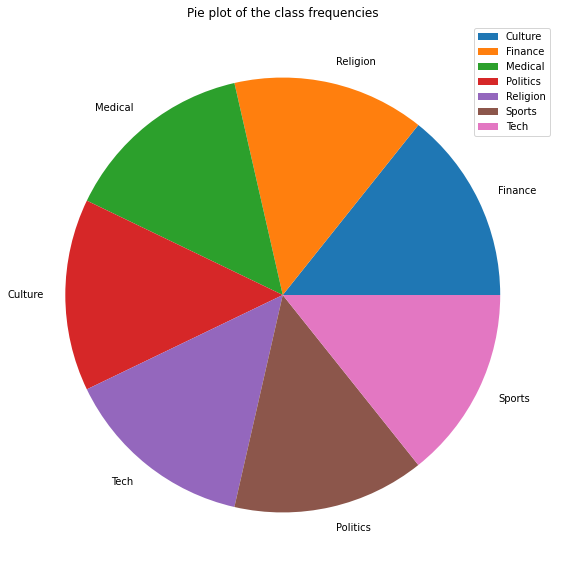

In [7]:
unique, counts = np.unique(y, return_counts=True)
plt.figure("classe Pie", figsize=(10, 10))
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=labels)
plt.legend(unique)
plt.show()

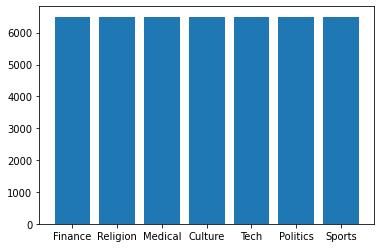

In [8]:
unique, counts = np.unique(y, return_counts=True)
plt.bar( labels,counts)
plt.show()

In [9]:
data =pd.DataFrame({"text":x,"label":y})

In [10]:
data.head()

,text,label
0,رأس الخيمة - عدنان عكاشة:قال د . عبد الله النع...,Medical
1,انخفض مؤشر سوق الإمارات منذ بداية العام الحالي...,Finance
2,أهدى الرئيس الشيشاني رمضان قديروف النجم المصري...,Sports
3,أعلن مكتب الملكة رانيا عقيلة العاهل الأردني ال...,Politics
4,حوار:جمال سالم يعد المستعرب والمستشرق الروسي «...,Religion


In [11]:
print('is null ? :  \n **************** ', data.isnull().sum())
print('data info : \n **************** ', data.info())
print('is duplicated : \n ************* ', data.duplicated().sum())
print('data shape \n :  ************** ', data.shape)

is null ? :  
 ****************  text     0
label    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45500 entries, 0 to 45499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    45500 non-null  object
 1   label   45500 non-null  object
dtypes: object(2)
memory usage: 711.1+ KB
data info : 
 ****************  None
is duplicated : 
 *************  15
data shape 
 :  **************  (45500, 2)


In [12]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0




<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>**Tokenization& Stop words**</center> </h1>

 

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
stop_words = list(set(stopwords.words('arabic')))

In [15]:
# remove punctuation from text
def remove_punctuation(text):
    # Add a space before and after each punctuation mark
    for char in string.punctuation:
        text = text.replace(char, ' ' + char + ' ')
    # Remove punctuation marks and extra spaces
    text = ' '.join(text.split())
    return text
# Tokenize text
def tokenize(text):
    # Define regex pattern to match Arabic letters and diacritics
    pattern = re.compile('[\u0621-\u064A\u064B-\u065F]+')
    # Remove punctuation from text and tokenize it
    tokens = nltk.word_tokenize(remove_punctuation(text))
    # Filter out stop words, non-Arabic words, and words less than 2 characters long
    arabic_tokens = [token for token in tokens if token not in stop_words and pattern.fullmatch(token)]
    return arabic_tokens
# # Remove punctuation from 'text' column
# data['no_punct'] = data['text'].apply(remove_punctuation)
# Tokenize 'no_punct' column
# data['tokenized'] = data['no_punct'].apply(tokenize)
data['tokenized'] = data['text'].apply(tokenize)
display_func = lambda x: pd.Series({'Original Text': x['text'], 'Tokenized Text': x['tokenized']})
# Apply the display function to the first 12 rows of the DataFrame
display_data = data.head(12).apply(display_func, axis=1)
print(display_data)

                                        Original Text  \
0   رأس الخيمة - عدنان عكاشة:قال د . عبد الله النع...   
1   انخفض مؤشر سوق الإمارات منذ بداية العام الحالي...   
2   أهدى الرئيس الشيشاني رمضان قديروف النجم المصري...   
3   أعلن مكتب الملكة رانيا عقيلة العاهل الأردني ال...   
4   حوار:جمال سالم يعد المستعرب والمستشرق الروسي «...   
5   أبوظبي:«الخليج» تراجع سوق أبوظبي للأوراق المال...   
6   دبي - مدحت السويفي:أكد خبراء في أسواق المال ال...   
7   بدأ رئيس جورجيا ميخائيل ساكاشفيلي وقادة المعار...   
8   أعلنت موتورولا مؤخراً أن شركة iDTGV، الشركة ال...   
9   1HP Compaq 6000 Pro- المعالج: Intel Core 2 Du،...   
10  كشف الدكتور سعيد الظاهري مستشار وزير الخارجية ...   
11  يكتب الروائي الفلسطيني، إبراهيم نصرالله في إحد...   

                                       Tokenized Text  
0   [رأس, الخيمة, عدنان, عكاشة, قال, عبد, الله, مد...  
1   [انخفض, مؤشر, سوق, الإمارات, بداية, العام, الح...  
2   [أهدى, الرئيس, الشيشاني, رمضان, قديروف, النجم,...  
3   [أعلن, مكتب, الملكة, رانيا, عق




<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>**Lematization**</center> </h1>

 

In [16]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
# Define a lemmatizer
lemmatizer = WordNetLemmatizer()
# Define a function to lemmatize each token in the tokenized text
def lemmatize(arabic_tokens):
    return [lemmatizer.lemmatize(word) for word in arabic_tokens]

# Apply lemmatizer to the tokenized 'text'
data['lemmatized'] = data['tokenized'].apply(lemmatize)

# Define a lambda function to display both the original, tokenized, and lemmatized text
display_func = lambda x: pd.Series({'Original Text': x['text'], 'Tokenized Text': x['tokenized'], 'Lemmatized Text': x['lemmatized']})

# Apply the display function to the first 12 rows of the DataFrame
display_data = data.head(20).apply(display_func, axis=1)
print(display_data)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                        Original Text  \
0   رأس الخيمة - عدنان عكاشة:قال د . عبد الله النع...   
1   انخفض مؤشر سوق الإمارات منذ بداية العام الحالي...   
2   أهدى الرئيس الشيشاني رمضان قديروف النجم المصري...   
3   أعلن مكتب الملكة رانيا عقيلة العاهل الأردني ال...   
4   حوار:جمال سالم يعد المستعرب والمستشرق الروسي «...   
5   أبوظبي:«الخليج» تراجع سوق أبوظبي للأوراق المال...   
6   دبي - مدحت السويفي:أكد خبراء في أسواق المال ال...   
7   بدأ رئيس جورجيا ميخائيل ساكاشفيلي وقادة المعار...   
8   أعلنت موتورولا مؤخراً أن شركة iDTGV، الشركة ال...   
9   1HP Compaq 6000 Pro- المعالج: Intel Core 2 Du،...   
10  كشف الدكتور سعيد الظاهري مستشار وزير الخارجية ...   
11  يكتب الروائي الفلسطيني، إبراهيم نصرالله في إحد...   
12  طالبت البنوك الوطنية هيئة الأوراق المالية والس...   
13  ساهم التدفق الكبير لاستثمارات الشركات الصغيرة ...   
14  إعداد: عبير حسين من اللحظة الأولى التي تطأ فيه...   
15  رأس الخيمة: محمد الدويري وفرت جمعية الإحسان ال...   
16  عجمان "الخليج":أشاد حمد تري

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['encodedLabel'] = label_encoder.fit_transform(data['label'])

data.head()

,text,label,tokenized,lemmatized,encodedLabel
0,رأس الخيمة - عدنان عكاشة:قال د . عبد الله النع...,Medical,"[رأس, الخيمة, عدنان, عكاشة, قال, عبد, الله, مد...","[رأس, الخيمة, عدنان, عكاشة, قال, عبد, الله, مد...",2
1,انخفض مؤشر سوق الإمارات منذ بداية العام الحالي...,Finance,"[انخفض, مؤشر, سوق, الإمارات, بداية, العام, الح...","[انخفض, مؤشر, سوق, الإمارات, بداية, العام, الح...",1
2,أهدى الرئيس الشيشاني رمضان قديروف النجم المصري...,Sports,"[أهدى, الرئيس, الشيشاني, رمضان, قديروف, النجم,...","[أهدى, الرئيس, الشيشاني, رمضان, قديروف, النجم,...",5
3,أعلن مكتب الملكة رانيا عقيلة العاهل الأردني ال...,Politics,"[أعلن, مكتب, الملكة, رانيا, عقيلة, العاهل, الأ...","[أعلن, مكتب, الملكة, رانيا, عقيلة, العاهل, الأ...",3
4,حوار:جمال سالم يعد المستعرب والمستشرق الروسي «...,Religion,"[حوار, جمال, سالم, يعد, المستعرب, والمستشرق, ا...","[حوار, جمال, سالم, يعد, المستعرب, والمستشرق, ا...",4


In [18]:
data.to_csv(r'./textClass_csv.csv', index = False)

In [19]:
data['encodedLabel'].value_counts()

2    6500
6    6500
1    6499
5    6499
3    6499
0    6495
4    6493
Name: encodedLabel, dtype: int64

In [20]:
X = data['lemmatized'] 
Y = data['encodedLabel']

In [21]:
number_of_labels = np.max(Y) + 1
print(number_of_labels)

7


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)
y_train.value_counts()

Training Data Shape: (36388,)
Testing Data Shape:  (9097,)


0    5263
2    5223
6    5213
1    5207
4    5190
5    5150
3    5142
Name: encodedLabel, dtype: int64




<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>Data Embding</center> </h1>

 

In [23]:
from keras.layers import Dropout, Dense, GRU, Embedding, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

In [24]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = X_train.astype(str)
text_test=X_test.astype(str)
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS,
                      char_level=False,
                       filters='”،,.":!"{#$%&()*+,-./:;<=>?@[\]^_`{|}\t\n',)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 383842 unique tokens.


In [25]:
x_train = pad_sequences(sequences, maxlen=300)
x_test = pad_sequences(sequences_test, maxlen=300)

In [26]:
x_train

array([[    0,     0,     0, ...,   578,   493,    71],
       [    0,     0,     0, ...,     5,  1074,  4983],
       [ 2300,  1786,   505, ...,   571,  4105, 17232],
       ...,
       [    0,     0,     0, ...,  7092, 16223, 11058],
       [ 3353,  1179,  3517, ..., 10067,  7106,  1560],
       [    0,     0,     0, ...,   666,  1871,   478]], dtype=int32)

In [27]:
x_test

array([[    0,     0,     0, ...,    33,  6423,  1080],
       [ 5945,   281,   773, ...,  6070,   484,    48],
       [  300,    25,  1283, ..., 18946,  1139,  2445],
       ...,
       [    0,     0,     0, ...,  9576,   429,    18],
       [    4,  2008,   368, ...,  2782,   538,     4],
       [    0,     0,     0, ..., 19588,  1440,  1440]], dtype=int32)

In [28]:
y_train.shape

(36388,)




<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>Recurrent Convolutional Neural Networks (RCNN)</center> </h1>

 

In [53]:
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Activation, Embedding
from keras.models import Sequential
import numpy as np

def Build_Model_RCNN_Text(word_index, number_of_labels, MAX_SEQUENCE_LENGTH=300, EMBEDDING_DIM=50):

    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256

    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(number_of_labels))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [54]:
from keras.utils import to_categorical

model = Build_Model_RCNN_Text(word_index, number_of_labels)



history=model.fit(x_train, y_train, validation_split=0.2,
                              epochs=10,
                              batch_size=128,
                              verbose=2)


Epoch 1/10
228/228 - 112s - loss: 1.5421 - accuracy: 0.3583 - val_loss: 1.5378 - val_accuracy: 0.3608 - 112s/epoch - 492ms/step
Epoch 2/10
228/228 - 93s - loss: 0.8530 - accuracy: 0.6469 - val_loss: 0.8456 - val_accuracy: 0.6524 - 93s/epoch - 409ms/step
Epoch 3/10
228/228 - 88s - loss: 0.6378 - accuracy: 0.7498 - val_loss: 0.8614 - val_accuracy: 0.6494 - 88s/epoch - 385ms/step
Epoch 4/10
228/228 - 83s - loss: 0.4628 - accuracy: 0.8305 - val_loss: 0.7388 - val_accuracy: 0.7330 - 83s/epoch - 364ms/step
Epoch 5/10
228/228 - 79s - loss: 0.3275 - accuracy: 0.8876 - val_loss: 0.7327 - val_accuracy: 0.7704 - 79s/epoch - 346ms/step
Epoch 6/10
228/228 - 77s - loss: 0.2659 - accuracy: 0.9093 - val_loss: 0.8085 - val_accuracy: 0.7409 - 77s/epoch - 338ms/step
Epoch 7/10
228/228 - 78s - loss: 0.2053 - accuracy: 0.9309 - val_loss: 0.8396 - val_accuracy: 0.7609 - 78s/epoch - 343ms/step
Epoch 8/10
228/228 - 75s - loss: 0.1624 - accuracy: 0.9463 - val_loss: 0.3875 - val_accuracy: 0.8869 - 75s/epoch - 3

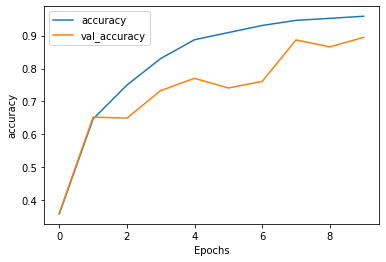

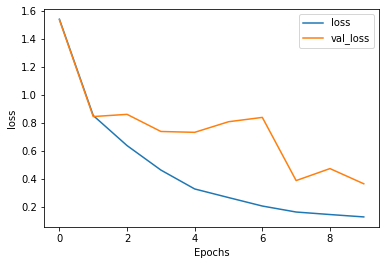

In [55]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [56]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

143/143 [==============================] - 4s 30ms/step - loss: 0.3373 - accuracy: 0.8973
Test loss: 0.3373326361179352
Test accuracy: 0.897328794002533





<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>Recurrent Neural Networks (RNN)</center> </h1>

 

In [57]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

def build_rnn_model(vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(LSTM(128))
    model.add(Dense(number_of_labels, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [58]:
from keras.utils import to_categorical
vocab_size = 500
embedding_dim = 32
maxlen = 300

y_train = to_categorical(y_train,number_of_labels)
y_test = to_categorical(y_test, number_of_labels)

model = build_rnn_model(vocab_size, embedding_dim, maxlen)

# Train the model and evaluate its performance
history=model.fit(x_train, y_train,validation_split=0.2, epochs=20, batch_size=32)


Epoch 1/20
910/910 [==============================] - 114s 122ms/step - loss: 1.4625 - accuracy: 0.4398 - val_loss: 1.2746 - val_accuracy: 0.4897
Epoch 2/20
910/910 [==============================] - 57s 63ms/step - loss: 1.0399 - accuracy: 0.6397 - val_loss: 0.8007 - val_accuracy: 0.7402
Epoch 3/20
910/910 [==============================] - 35s 38ms/step - loss: 0.6987 - accuracy: 0.7723 - val_loss: 0.7432 - val_accuracy: 0.7350
Epoch 4/20
910/910 [==============================] - 26s 29ms/step - loss: 0.5736 - accuracy: 0.8210 - val_loss: 0.3973 - val_accuracy: 0.8939
Epoch 5/20
910/910 [==============================] - 23s 26ms/step - loss: 0.6750 - accuracy: 0.8003 - val_loss: 0.6082 - val_accuracy: 0.8261
Epoch 6/20
910/910 [==============================] - 18s 20ms/step - loss: 0.7863 - accuracy: 0.7326 - val_loss: 0.8606 - val_accuracy: 0.7234
Epoch 7/20
910/910 [==============================] - 17s 18ms/step - loss: 0.5491 - accuracy: 0.8357 - val_loss: 0.4916 - val_accurac

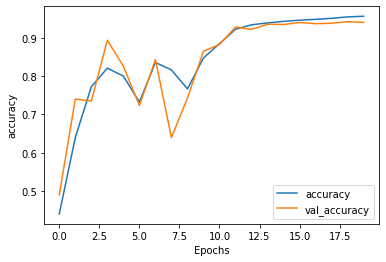

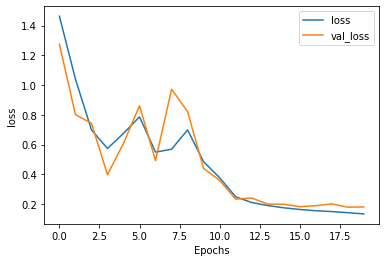

In [59]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [60]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

143/143 [==============================] - 1s 7ms/step - loss: 0.1745 - accuracy: 0.9431
Test loss: 0.17447437345981598
Test accuracy: 0.9430581331253052





<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>Convolutional Neural Networks (CNN)</center> </h1>

 

In [61]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Concatenate, Embedding

def build_model_cnn_text(word_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
   
    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))

    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        #l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(number_of_labels, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [62]:
from keras.utils import to_categorical

nclasses = 7
MAX_SEQUENCE_LENGTH=300
EMBEDDING_DIM = 50
dropout = 0.5
model = build_model_cnn_text(word_index, nclasses, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, dropout)



history=model.fit(x_train, y_train, validation_split=0.2,
                              epochs=10,
                              batch_size=128,
                              verbose=2)



Filter   5
Epoch 1/10
228/228 - 35s - loss: 1.7359 - accuracy: 0.2826 - val_loss: 1.3514 - val_accuracy: 0.5038 - 35s/epoch - 151ms/step
Epoch 2/10
228/228 - 28s - loss: 0.8865 - accuracy: 0.6305 - val_loss: 0.7761 - val_accuracy: 0.8042 - 28s/epoch - 121ms/step
Epoch 3/10
228/228 - 23s - loss: 0.4028 - accuracy: 0.8519 - val_loss: 0.4544 - val_accuracy: 0.8954 - 23s/epoch - 101ms/step
Epoch 4/10
228/228 - 19s - loss: 0.1852 - accuracy: 0.9369 - val_loss: 0.2829 - val_accuracy: 0.9308 - 19s/epoch - 83ms/step
Epoch 5/10
228/228 - 18s - loss: 0.1278 - accuracy: 0.9578 - val_loss: 0.3435 - val_accuracy: 0.9378 - 18s/epoch - 77ms/step
Epoch 6/10
228/228 - 18s - loss: 0.0858 - accuracy: 0.9728 - val_loss: 0.2169 - val_accuracy: 0.9461 - 18s/epoch - 78ms/step
Epoch 7/10
228/228 - 15s - loss: 0.0575 - accuracy: 0.9819 - val_loss: 0.1928 - val_accuracy: 0.9438 - 15s/epoch - 67ms/step
Epoch 8/10
228/228 - 14s - loss: 0.0517 - accuracy: 0.9848 - val_loss: 0.1707 - val_accuracy: 0.9569 - 14s/epoc

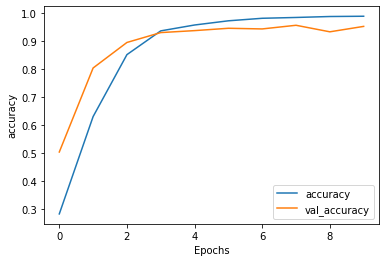

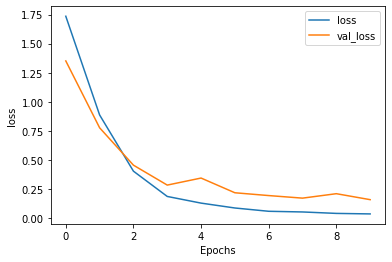

In [63]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [64]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

143/143 [==============================] - 1s 8ms/step - loss: 0.1407 - accuracy: 0.9587
Test loss: 0.1406591385602951
Test accuracy: 0.9586676955223083





<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center> Convolutional Neural Networks (CNN) with KeraStuner</center> </h1>

 

In [29]:
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch
from keras.utils import to_categorical

def build_model_cnn_text(hp):
    nclasses = 5
    MAX_SEQUENCE_LENGTH = 300
    EMBEDDING_DIM = 50
    
    layer = 5
    print("Filter  ", layer)
    filter_sizes = []
    for fl in range(0, layer):
        filter_sizes.append((fl+2))

    node = 128
    
    sequence_input = keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    
    # Define hyperparameters
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    dropout = hp.Float('dropout', 0.1, 0.5, step=0.1)

    embedding_layer = layers.Embedding(len(word_index) + 1,
                                       EMBEDDING_DIM,
                                       weights=[embedding_matrix],
                                       input_length=MAX_SEQUENCE_LENGTH,
                                       trainable=True)

    convs = []
    embedded_sequences = embedding_layer(sequence_input)
    
    for fsz in filter_sizes:
        l_conv = layers.Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = layers.MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = layers.Concatenate(axis=1)(convs)
    l_cov1 = layers.Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = layers.Dropout(dropout)(l_cov1)
    l_pool1 = layers.MaxPooling1D(5)(l_cov1)
    l_cov2 = layers.Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = layers.Dropout(dropout)(l_cov2)
    l_pool2 = layers.MaxPooling1D(30)(l_cov2)
    l_flat = layers.Flatten()(l_pool2)
    l_dense = layers.Dense(1024, activation='relu')(l_flat)
    l_dense = layers.Dropout(dropout)(l_dense)
    l_dense = layers.Dense(512, activation='relu')(l_dense)
    l_dense = layers.Dropout(dropout)(l_dense)
    preds = layers.Dense(number_of_labels, activation='softmax')(l_dense)
    model = keras.Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model_cnn_text,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld')

y_train = to_categorical(y_train,number_of_labels)
y_test = to_categorical(y_test, number_of_labels)

tuner.search_space_summary()

tuner.search(x_train, y_train,
             epochs=10,
             validation_split=0.2)

tuner.results_summary()

# Retrieve the best model and evaluate it on the test data
best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 05m 26s]
val_accuracy: 0.9539708495140076

Best val_accuracy So Far: 0.9604287147521973
Total elapsed time: 00h 18m 18s
Results summary
Results in my_dir/helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.5
Score: 0.9604287147521973
Trial summary
Hyperparameters:
dropout: 0.4
Score: 0.9602912664413452
Trial summary
Hyperparameters:
dropout: 0.2
Score: 0.9539708495140076
Filter   5


In [30]:
# Evaluate the accuracy of our trained model
score = best_model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

143/143 [==============================] - 2s 9ms/step - loss: 0.1430 - accuracy: 0.9609
Test loss: 0.1429819017648697
Test accuracy: 0.9608662128448486





<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>RNN with KerasTunner</center> </h1>

 

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch
from keras.utils import to_categorical

def build_rnn_model(hp):
    vocab_size = 10000  # Replace with your actual vocabulary size
    maxlen = 300  # Replace with your actual maximum sequence length
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=512, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=512, step=32)
  

    model = keras.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.LSTM(units=lstm_units))
    model.add(layers.Dense(number_of_labels, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the search space for hyperparameters
tuner = RandomSearch(
    build_rnn_model,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)
y_train = to_categorical(y_train,number_of_labels)
y_test = to_categorical(y_test, number_of_labels)
# # Perform the hyperparameter search
tuner.search(x=x_train, y=y_train, epochs=5, validation_data=(x_test, y_test))

# Get the best hyperparameters and retrain the model on all data
best_hp = tuner.get_best_hyperparameters()[0]
model = build_rnn_model(best_hp)
history=model.fit(x_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
910/910 [==============================] - 136s 142ms/step - loss: 1.1214 - accuracy: 0.5876 - val_loss: 0.4224 - val_accuracy: 0.8787
Epoch 2/10
910/910 [==============================] - 68s 75ms/step - loss: 0.4651 - accuracy: 0.8559 - val_loss: 0.3040 - val_accuracy: 0.9215
Epoch 3/10
910/910 [==============================] - 54s 59ms/step - loss: 0.2239 - accuracy: 0.9356 - val_loss: 0.2159 - val_accuracy: 0.9412
Epoch 4/10
910/910 [==============================] - 47s 52ms/step - loss: 0.2123 - accuracy: 0.9415 - val_loss: 0.1795 - val_accuracy: 0.9536
Epoch 5/10
910/910 [==============================] - 41s 45ms/step - loss: 0.1231 - accuracy: 0.9660 - val_loss: 0.1556 - val_accuracy: 0.9611
Epoch 6/10
910/910 [==============================] - 39s 42ms/step - loss: 0.0767 - accuracy: 0.9815 - val_loss: 0.1872 - val_accuracy: 0.9562
Epoch 7/10
910/910 [==============================] - 38s 42ms/step - loss: 0.3028 - accuracy: 0.9235 - val_loss: 0.2065 - val_accurac

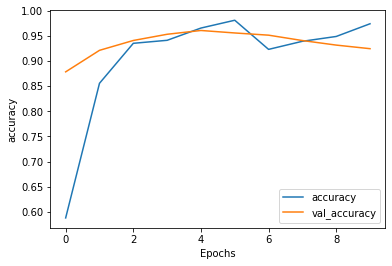

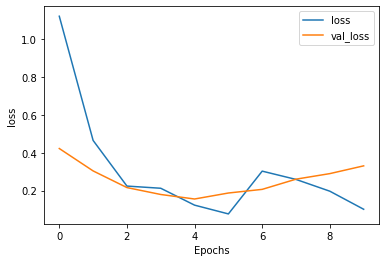

In [31]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

143/143 [==============================] - 3s 24ms/step - loss: 0.3287 - accuracy: 0.9295
Test loss: 0.3286524713039398
Test accuracy: 0.9295372366905212


<a id = '2'></a>
## <h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> ## Arabiya dataset </center></h1> 

In [2]:

# Define path to zip file and directory to extract
zip_path = '/content/Arabiya.zip'
extract_path = '/content/Arabiya'
# Create a GPU device to use
device = '/device:GPU:0'
# Define a function to unzip the file
def unzip_file(zip_path, extract_path):
    with tf.device(device):
        os.system('unzip -q {} -d {}'.format(zip_path, extract_path))
# Call the function to unzip the file
unzip_file(zip_path, extract_path)

In [3]:
#load data as tf.data.Dataset
seed=42
data_paths = '/content/Arabiya'
labels=os.listdir(data_paths) 
raw_data = tf.keras.preprocessing.text_dataset_from_directory(
    data_paths,
    labels="inferred",
    label_mode="int",
    max_length=None,
    shuffle=True,
    seed=seed,
    validation_split=None,
    subset=None,
    follow_links=False,
)

Found 71246 files belonging to 7 classes.


In [4]:
print("Classes names:\n",raw_data.class_names)

Classes names:
 ['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']


In [5]:
x=[]
y=[]
for text_batch, label_batch in raw_data:
    for i in range(len(text_batch)):
        s=text_batch.numpy()[i].decode("utf-8") 
        x.append(s)
        y.append(raw_data.class_names[label_batch.numpy()[i]])
        #print(label_batch.numpy()[i])
print(len(x))
print(len(y))

71246
71246


In [6]:
x[:1] , y[:1]

(['أخفق وزراء الخزانة والمال لدول الاتحاد الأوروبي في أعقاب سلسلة من الاجتماعات في بروكسل استمرت طوال اليومين الماضيين في تسجيل أي تقدم بين دولهم بشأن إرساء الجوانب الأخيرة من الاتحاد البنكي الأوروبي. ورغم سلسلة اجتماعات سبقت، لم يتوصل ساسة المال الأوربيون إلى توافق حول صيغة التفاوض مع البرلمان الأوروبي. وأوضح متحدث أوروبي، بحسب ما نقلته وكالات أنباء، أن نقاط الخلاف عميقة والوزراء لم يكلفوا الرئاسة الدورية الأوروبية التي تتولاها اليونان بأية مهمة محددة لتجاوز العقبات الحالية. وكانت الدول الأوروبية توصلت في ديسمبر الماضي إلى اتفاق مبدئي حول آلية لإنقاذ البنوك المتعثرة بعد اتفاقها على آلية الإشراف على المصارف لتجنب تحميل دافعي الضرائب تبعات الأزمة. وطالب البرلمان الأوروبي بتدابير ملزمة بالنسبة لإنقاذ البنوك واقتسام صلاحية ذلك مع الحكومات، ما تسبب بسلسلة من التعثر في المباحثات.'],
 ['Finance'])

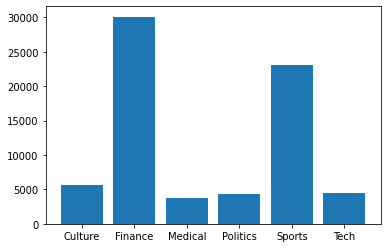

In [7]:
unique, counts = np.unique(y, return_counts=True)
unique, counts = np.unique(y, return_counts=True)
labels = [format(i) for i in unique]
plt.bar( labels,counts)
plt.show()

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
# Rq:we have unblanced dataset

In [8]:
data =pd.DataFrame({"text":x,"label":y})

In [9]:
import pandas as pd
from sklearn.utils import resample


# Check the distribution of target classes
target_distribution = data['label'].value_counts(normalize=True)
print(target_distribution)

# Set target class size to the size of the smallest class
target_class_size = data['label'].value_counts().min()

# Upsample each class to match the target class size
balanced_data = pd.DataFrame()
for target_class in data['label'].unique():
    class_data = data[data['label'] == target_class]
    upsampled_class_data = resample(class_data,
                                    replace=True,  # sample with replacement
                                    n_samples=target_class_size,  # to match target class size
                                    random_state=42)  # reproducible results
    balanced_data = pd.concat([balanced_data, upsampled_class_data])

# Check the distribution of target classes in balanced data
balanced_target_distribution = balanced_data['label'].value_counts(normalize=True)
print(balanced_target_distribution)




Finance     0.422143
Sports      0.323639
Culture     0.078868
Tech        0.061898
Politics    0.061309
Medical     0.052143
Name: label, dtype: float64
Finance     0.166667
Sports      0.166667
Medical     0.166667
Tech        0.166667
Culture     0.166667
Politics    0.166667
Name: label, dtype: float64


In [10]:
balanced_target_distribution[:]

Finance     0.166667
Sports      0.166667
Medical     0.166667
Tech        0.166667
Culture     0.166667
Politics    0.166667
Name: label, dtype: float64

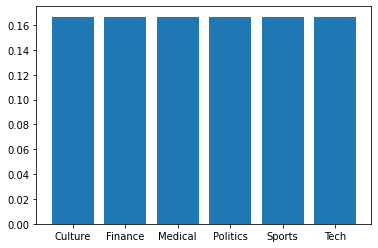

In [11]:
counts=balanced_target_distribution[:]
plt.bar( labels,counts)
plt.show()

In [12]:
#create the vocab 
vocab = sorted(set(' '.join(x))) 

In [13]:
data.head(10)

,text,label
0,أخفق وزراء الخزانة والمال لدول الاتحاد الأوروب...,Finance
1,وجّه الروماني لورينتو ريجيكامب مدرب الهلال رسا...,Sports
2,من أجل اتباع نظام غذائي صحي خلال شهر رمضان يتو...,Medical
3,حذرت إيطاليا تجار النفط من احتمال مواجهة إجراء...,Finance
4,"أعلنت خدمة الإعلانات ""آد وردز"" AdWords التابعة...",Tech
5,قفزت مؤشرات البورصة المصرية بنسب كبيرة، محققة ...,Finance
6,يملك سيرجيو أغويرو سجلا جيدا في مواجهة برشلونة...,Sports
7,نمت أرباح بنك أوف تشاينا، رابع أكبر بنك تجاري ...,Finance
8,أكد المدير التنفيذي للاتحاد الدولي للنقل الجوي...,Finance
9,رغم أن أجور الأطباء في جميع دول العالم تعتبر ا...,Finance


In [14]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0




<h1 style="color:#3f8068; font-style:italic; font-family:Cursive;"> <center>## Tokenization & Stop words</center> </h1>

 

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
stop_words = list(set(stopwords.words('arabic')))

In [17]:
# remove punctuation from text
def remove_punctuation(text):
    # Add a space before and after each punctuation mark
    for char in string.punctuation:
        text = text.replace(char, ' ' + char + ' ')
    # Remove punctuation marks and extra spaces
    text = ' '.join(text.split())
    return text
# Tokenize text
def tokenize(text):
    # Define regex pattern to match Arabic letters and diacritics
    pattern = re.compile('[\u0621-\u064A\u064B-\u065F]+')
    # Remove punctuation from text and tokenize it
    tokens = nltk.word_tokenize(remove_punctuation(text))
    # Filter out stop words, non-Arabic words, and words less than 2 characters long
    arabic_tokens = [token for token in tokens if token not in stop_words and pattern.fullmatch(token)]
    return arabic_tokens
# # Remove punctuation from 'text' column
# data['no_punct'] = data['text'].apply(remove_punctuation)
# Tokenize 'no_punct' column
# data['tokenized'] = data['no_punct'].apply(tokenize)
data['tokenized'] = data['text'].apply(tokenize)
display_func = lambda x: pd.Series({'Original Text': x['text'], 'Tokenized Text': x['tokenized']})
# Apply the display function to the first 12 rows of the DataFrame
display_data = data.head(12).apply(display_func, axis=1)
print(display_data)

                                        Original Text  \
0   أخفق وزراء الخزانة والمال لدول الاتحاد الأوروب...   
1   وجّه الروماني لورينتو ريجيكامب مدرب الهلال رسا...   
2   من أجل اتباع نظام غذائي صحي خلال شهر رمضان يتو...   
3   حذرت إيطاليا تجار النفط من احتمال مواجهة إجراء...   
4   أعلنت خدمة الإعلانات "آد وردز" AdWords التابعة...   
5   قفزت مؤشرات البورصة المصرية بنسب كبيرة، محققة ...   
6   يملك سيرجيو أغويرو سجلا جيدا في مواجهة برشلونة...   
7   نمت أرباح بنك أوف تشاينا، رابع أكبر بنك تجاري ...   
8   أكد المدير التنفيذي للاتحاد الدولي للنقل الجوي...   
9   رغم أن أجور الأطباء في جميع دول العالم تعتبر ا...   
10  قال رئيس الوزراء التركي رجب طيب أردوغان اليوم ...   
11  قال وزير الطاقة الأميركي، إرنست مونيز، إنه يتو...   

                                       Tokenized Text  
0   [أخفق, وزراء, الخزانة, والمال, لدول, الاتحاد, ...  
1   [وجّه, الروماني, لورينتو, ريجيكامب, مدرب, الهل...  
2   [اتباع, نظام, غذائي, صحي, خلال, شهر, رمضان, يت...  
3   [حذرت, إيطاليا, تجار, النفط, ا




<h1 style="color:#3f8068; font-style:italic; font-family:Cursive;"> <center>Stematization</center> </h1>

 

In [18]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.isri import ISRIStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
# Define a lemmatizer
lemmatizer = WordNetLemmatizer()
# Define a function to lemmatize each token in the tokenized text
def lemmatize(arabic_tokens):
    return [lemmatizer.lemmatize(word) for word in arabic_tokens]

# Apply lemmatizer to the tokenized 'text'
data['lemmatized'] = data['tokenized'].apply(lemmatize)

# Define an instance of the ISRIStemmer
stemmer = ISRIStemmer()

# Lemmatize each word using the ISRIStemmer
def stematize(arabic_tokens):
    return [stemmer.stem(word) for word in arabic_tokens]
data['stematized'] = data['lemmatized'].apply(stematize)

# Define a lambda function to display both the original, tokenized, and lemmatized text
display_func = lambda x: pd.Series({'Original Text': x['text'], 'Tokenized Text': x['tokenized'], 'Lemmatized Text': x['lemmatized'],
                                    'stematization Text': x['stematized']})


# Apply the display function to the first 12 rows of the DataFrame
display_data = data.head(20).apply(display_func, axis=1)
print(display_data)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                        Original Text  \
0   أخفق وزراء الخزانة والمال لدول الاتحاد الأوروب...   
1   وجّه الروماني لورينتو ريجيكامب مدرب الهلال رسا...   
2   من أجل اتباع نظام غذائي صحي خلال شهر رمضان يتو...   
3   حذرت إيطاليا تجار النفط من احتمال مواجهة إجراء...   
4   أعلنت خدمة الإعلانات "آد وردز" AdWords التابعة...   
5   قفزت مؤشرات البورصة المصرية بنسب كبيرة، محققة ...   
6   يملك سيرجيو أغويرو سجلا جيدا في مواجهة برشلونة...   
7   نمت أرباح بنك أوف تشاينا، رابع أكبر بنك تجاري ...   
8   أكد المدير التنفيذي للاتحاد الدولي للنقل الجوي...   
9   رغم أن أجور الأطباء في جميع دول العالم تعتبر ا...   
10  قال رئيس الوزراء التركي رجب طيب أردوغان اليوم ...   
11  قال وزير الطاقة الأميركي، إرنست مونيز، إنه يتو...   
12  اختتم فريق الرائد السعودي المرحلة الثانية من ب...   
13  وجد نحو 20 ألف مسافر أنفسهم عالقين أمس السبت، ...   
14  تراجع صافي أرباح شركة "جبل عمر" في العام المنص...   
15  تجاهل المدير الفني لمانشستر يونايتد، ديفيد موي...   
16  كشف الجزائري الدولي إدريس س

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['encodedLabel'] = label_encoder.fit_transform(data['label'])

data.head()

,text,label,tokenized,lemmatized,stematized,encodedLabel
0,أخفق وزراء الخزانة والمال لدول الاتحاد الأوروب...,Finance,"[أخفق, وزراء, الخزانة, والمال, لدول, الاتحاد, ...","[أخفق, وزراء, الخزانة, والمال, لدول, الاتحاد, ...","[خفق, زرء, خزن, مال, لدل, تحد, ورب, عقب, لسل, ...",1
1,وجّه الروماني لورينتو ريجيكامب مدرب الهلال رسا...,Sports,"[وجّه, الروماني, لورينتو, ريجيكامب, مدرب, الهل...","[وجّه, الروماني, لورينتو, ريجيكامب, مدرب, الهل...","[وجه, روم, رينتو, ريجيكامب, درب, هلل, رسل, وضح...",4
2,من أجل اتباع نظام غذائي صحي خلال شهر رمضان يتو...,Medical,"[اتباع, نظام, غذائي, صحي, خلال, شهر, رمضان, يت...","[اتباع, نظام, غذائي, صحي, خلال, شهر, رمضان, يت...","[تبع, نظم, غذي, صحي, خلل, شهر, رمض, وجب, قسم, ...",2
3,حذرت إيطاليا تجار النفط من احتمال مواجهة إجراء...,Finance,"[حذرت, إيطاليا, تجار, النفط, احتمال, مواجهة, إ...","[حذرت, إيطاليا, تجار, النفط, احتمال, مواجهة, إ...","[حذر, يطل, تجر, نفط, حمل, وجه, جرء, قنو, جنب, ...",1
4,"أعلنت خدمة الإعلانات ""آد وردز"" AdWords التابعة...",Tech,"[أعلنت, خدمة, الإعلانات, آد, وردز, التابعة, لش...","[أعلنت, خدمة, الإعلانات, آد, وردز, التابعة, لش...","[اعل, خدم, علن, اد, ردز, ابع, لشر, غوغل, انه, ...",5


In [20]:
data.to_csv(r'./textClass_csv.csv', index = False)

In [21]:
data['encodedLabel'].value_counts()

1    30063
4    23057
0     5619
5     4409
3     4347
2     3715
Name: encodedLabel, dtype: int64

In [22]:
X = data['lemmatized'] 
Y = data['encodedLabel']

In [23]:
number_of_labels = np.max(Y) + 1
print(number_of_labels)

6


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)
y_train.value_counts()

Training Data Shape: (56968,)
Testing Data Shape:  (14242,)


1    24029
4    18385
0     4541
5     3532
3     3491
2     2990
Name: encodedLabel, dtype: int64

In [25]:
from keras.layers import Dropout, Dense, GRU, Embedding, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

In [26]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = X_train.astype(str)
text_test=X_test.astype(str)
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS,
                      char_level=False,
                       filters='”،,.":!"{#$%&()*+,-./:;<=>?@[\]^_`{|}\t\n',)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 277164 unique tokens.


In [27]:
x_train = pad_sequences(sequences, maxlen=300)
x_test = pad_sequences(sequences_test, maxlen=300)




<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>Recurrent Neural Networks (RNN) with KerasTunner</center> </h1>

 

In [36]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch
from keras.utils import to_categorical

def build_rnn_model(hp):
    vocab_size = 10000  # Replace with your actual vocabulary size
    maxlen = 300  # Replace with your actual maximum sequence length
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=512, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=512, step=32)
  

    model = keras.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.LSTM(units=lstm_units))
    model.add(layers.Dense(number_of_labels, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the search space for hyperparameters
tuner = RandomSearch(
    build_rnn_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='my_project'
)
y_train = to_categorical(y_train,number_of_labels)
y_test = to_categorical(y_test, number_of_labels)
# Perform the hyperparameter search
tuner.search(x=x_train, y=y_train, epochs=5, validation_data=(x_test, y_test))

# Get the best hyperparameters and retrain the model on all data
best_hp = tuner.get_best_hyperparameters()[0]
model = build_rnn_model(best_hp)
history=model.fit(x_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
1425/1425 [==============================] - 178s 123ms/step - loss: 0.6118 - accuracy: 0.7629 - val_loss: 0.4396 - val_accuracy: 0.8147
Epoch 2/10
1425/1425 [==============================] - 76s 54ms/step - loss: 0.3755 - accuracy: 0.8620 - val_loss: 0.3124 - val_accuracy: 0.8790
Epoch 3/10
1425/1425 [==============================] - 62s 44ms/step - loss: 0.3741 - accuracy: 0.8785 - val_loss: 0.2387 - val_accuracy: 0.9203
Epoch 4/10
1425/1425 [==============================] - 58s 41ms/step - loss: 0.1689 - accuracy: 0.9539 - val_loss: 0.1656 - val_accuracy: 0.9552
Epoch 5/10
1425/1425 [==============================] - 56s 39ms/step - loss: 0.0907 - accuracy: 0.9775 - val_loss: 0.1183 - val_accuracy: 0.9697
Epoch 6/10
1425/1425 [==============================] - 57s 40ms/step - loss: 0.0710 - accuracy: 0.9828 - val_loss: 0.1231 - val_accuracy: 0.9708
Epoch 7/10
1425/1425 [==============================] - 58s 41ms/step - loss: 0.0482 - accuracy: 0.9882 - val_loss: 0.1229

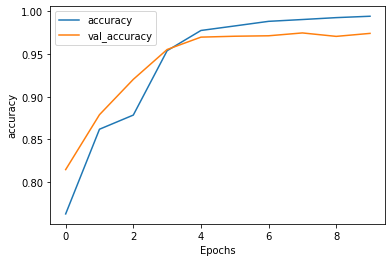

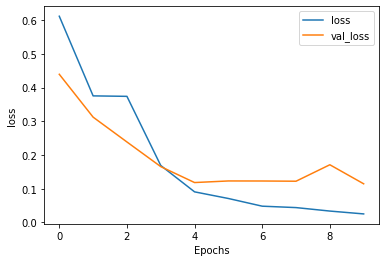

In [37]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
  

In [38]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

223/223 [==============================] - 6s 25ms/step - loss: 0.1079 - accuracy: 0.9746
Test loss: 0.1079317107796669
Test accuracy: 0.9745821952819824





<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>Convolutional Neural Networks (CNN) with KeraStuner</center> </h1>

 

In [41]:
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch
from keras.utils import to_categorical

def build_model_cnn_text(hp):
    MAX_SEQUENCE_LENGTH = 300
    EMBEDDING_DIM = 50
    
    layer = 5
    print("Filter  ", layer)
    filter_sizes = []
    for fl in range(0, layer):
        filter_sizes.append((fl+2))

    node = 128
    
    sequence_input = keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    
    # Define hyperparameters
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    dropout = hp.Float('dropout', 0.1, 0.5, step=0.1)

    embedding_layer = layers.Embedding(len(word_index) + 1,
                                       EMBEDDING_DIM,
                                       weights=[embedding_matrix],
                                       input_length=MAX_SEQUENCE_LENGTH,
                                       trainable=True)

    convs = []
    embedded_sequences = embedding_layer(sequence_input)
    
    for fsz in filter_sizes:
        l_conv = layers.Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = layers.MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = layers.Concatenate(axis=1)(convs)
    l_cov1 = layers.Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = layers.Dropout(dropout)(l_cov1)
    l_pool1 = layers.MaxPooling1D(5)(l_cov1)
    l_cov2 = layers.Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = layers.Dropout(dropout)(l_cov2)
    l_pool2 = layers.MaxPooling1D(30)(l_cov2)
    l_flat = layers.Flatten()(l_pool2)
    l_dense = layers.Dense(1024, activation='relu')(l_flat)
    l_dense = layers.Dropout(dropout)(l_dense)
    l_dense = layers.Dense(512, activation='relu')(l_dense)
    l_dense = layers.Dropout(dropout)(l_dense)
    preds = layers.Dense(number_of_labels, activation='softmax')(l_dense)
    model = keras.Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model_cnn_text,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld')

# y_train = to_categorical(y_train,number_of_labels)
# y_test = to_categorical(y_test, number_of_labels)

tuner.search_space_summary()

tuner.search(x_train, y_train,
             epochs=10,
             validation_split=0.2)


tuner.results_summary()


# Get the best hyperparameters and retrain the model on all data
best_hp = tuner.get_best_hyperparameters()[0]
model = build_model_cnn_text(best_hp)
history=model.fit(x_train, y_train, epochs=10, validation_split=0.2)

Search space summary
Default search space size: 1
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
Results summary
Results in my_dir/helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
dropout: 0.5
Score: 0.9604287147521973
Trial summary
Hyperparameters:
dropout: 0.4
Score: 0.9602912664413452
Trial summary
Hyperparameters:
dropout: 0.2
Score: 0.9539708495140076
Filter   5
Epoch 1/10
1425/1425 [==============================] - 154s 100ms/step - loss: 0.7780 - accuracy: 0.6866 - val_loss: 0.4600 - val_accuracy: 0.8374
Epoch 2/10
1425/1425 [==============================] - 56s 39ms/step - loss: 0.1572 - accuracy: 0.9552 - val_loss: 0.2295 - val_accuracy: 0.9300
Epoch 3/10
1425/1425 [==============================] - 36s 26ms/step - loss: 0.1007 - accuracy: 0.9720 - val_loss: 0.1700 - val_accuracy: 0.9536
Epoch 4/10
1425/1425 [==============================] - 36s 25ms/step - loss: 0.0753 - accuracy: 0.

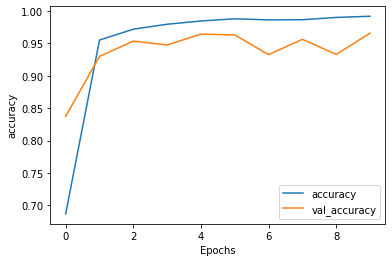

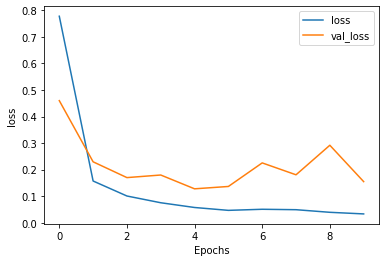

In [43]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [42]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=64, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

223/223 [==============================] - 2s 9ms/step - loss: 0.1425 - accuracy: 0.9669
Test loss: 0.14246200025081635
Test accuracy: 0.9669287800788879
